In [1]:
!pip install transformers --quiet
!pip install pydot --quiet

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from transformers import BertTokenizer, TFBertModel

2023-08-06 21:33:11.432787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# from google.colab import drive

# drive.mount('/content/drive')
DataPath = '/Users/ratsimbazafy/Downloads/random_reviews.csv'

In [4]:
#Load data from csv file
df = pd.read_csv(DataPath, names=["score", "text"], header=0, usecols=[0, 1])
df.dropna(subset=['text'], inplace=True)
df['score'] = df['score'] - 1

df.head()

,score,text
0,1,Food was very disappointing. Most of the food ...
1,2,"The food and service here is good. However, ha..."
2,4,If u want to relax have the best drinks and mo...
3,1,I went along with my friends to this restauran...
4,1,If good food is what u want to eat look somewh...


In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = [str(text) for text in train_df['text'].tolist()]
test_texts = [str(text) for text in test_df['text'].tolist()]
train_labels = np.array(train_df['score'], dtype=np.int64)
test_labels = np.array(test_df['score'], dtype=np.int64)

In [6]:
#Quickly checking input data types and shapes

train_texts[:2]
train_labels[:100]

print(type(train_texts))
print(len(train_texts))
print(type(test_texts))
print(len(test_texts))
print(type(train_labels))
print(len(train_labels))
print(train_labels.dtype)
print(type(test_labels))
print(len(test_labels))
print(test_labels.dtype)

<class 'list'>
17820
<class 'list'>
4455
<class 'numpy.ndarray'>
17820
int64
<class 'numpy.ndarray'>
4455
int64


In [7]:
#Re-asserting labal names as integers with values 1-5 (removing the offset to start from zero)
target_names = ['1', '2', '3', '4', '5']
print(target_names)

['1', '2', '3', '4', '5']


In [8]:
#Casting part of training set itself for validation

len(train_texts)
valid_texts = train_texts[15000:]
valid_labels = train_labels[15000:]
train_texts = train_texts[:15000]
train_labels = train_labels[:15000]

print(len(valid_texts))
print(len(train_texts))


2820
15000


In [9]:
#Get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

In [10]:
#Necessary BERT commands
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

2023-08-06 21:33:18.571421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from

In [11]:
#Setting max length param
max_length = 128

In [12]:
# tokenize the dataset, truncate when passed `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [13]:
#Check input ids
train_encodings.input_ids[:1]

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  6467,   170,  1363,  2541,  1303,   119,  1109,  1148,
         1645,  1141, 15749,  1110,  1103,  1821, 12324,  2093,   117,
         1134,  1110,  1632,   119,  1135,  1110,  5098,   170,  4321,
        13994,  4382,  1114,  1363,  6665,  1241,  1107,  2076,  1105,
         1103,  1295,   119,  1284,  1125,  1270,  1111,  1126,  4035,
         4313, 23850,  1161,  9323,  1105,  9323,  4104, 15650,  4862,
          119,  1109,  3849,  1104,  1241, 10514,  1127, 11769,  3121,
        16268,   119,  1109,  3068,  1104,  1103,  9323,  1108,  6548,
          119,  2695, 10514,  1127, 12477, 24941, 12769,  1105, 22593,
        23140,  6334,  2365,   119,  1109,  2613,  2546,  1110,  1145,
         6548,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

# Multiclass BERT Model

In [14]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 5,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name ='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    #Hidden size
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes , activation='softmax',name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs = classification)


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')
    return classification_model

In [15]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
pooler_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

In [17]:
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
#Should take a few 10mins to run, depending how stacked hyper-params are
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=64,
                                                  epochs=1)

235/235 [==============================] - 43569s 186s/step - loss: 1.0811 - accuracy: 0.5156 - val_loss: 0.9437 - val_accuracy: 0.5957


In [19]:
#Batch 8, ML=10
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

140/140 [==============================] - 546s 4s/step - loss: 0.9245 - accuracy: 0.5964
Test loss: 0.924538254737854
Test accuracy: 0.5964085459709167


In [20]:
#Running predictions for the first 3 elements in the test dataset
predictions = pooler_bert_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

1/1 [==============================] - 4s 4s/step


In [21]:
predictions

array([[0.00417539, 0.00135207, 0.00407661, 0.00907442, 0.9813215 ],
       [0.00766303, 0.02376852, 0.2994371 , 0.4806105 , 0.18852082],
       [0.00431804, 0.01279849, 0.06887401, 0.37086993, 0.5431395 ]],
      dtype=float32)

In [22]:
#Running predictions for the entirety of the test dataset

predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

140/140 [==============================] - 4986s 36s/step


<tf.Tensor: shape=(4455,), dtype=int64, numpy=array([4, 3, 4, ..., 4, 2, 3])>

In [23]:
print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))

              precision    recall  f1-score   support

           1       0.71      0.70      0.71       930
           2       0.50      0.48      0.49       900
           3       0.54      0.60      0.57       869
           4       0.59      0.37      0.46       880
           5       0.62      0.83      0.71       876

    accuracy                           0.60      4455
   macro avg       0.59      0.60      0.59      4455
weighted avg       0.59      0.60      0.59      4455



In [24]:
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(58.222222222222214, 0.5, 'True')

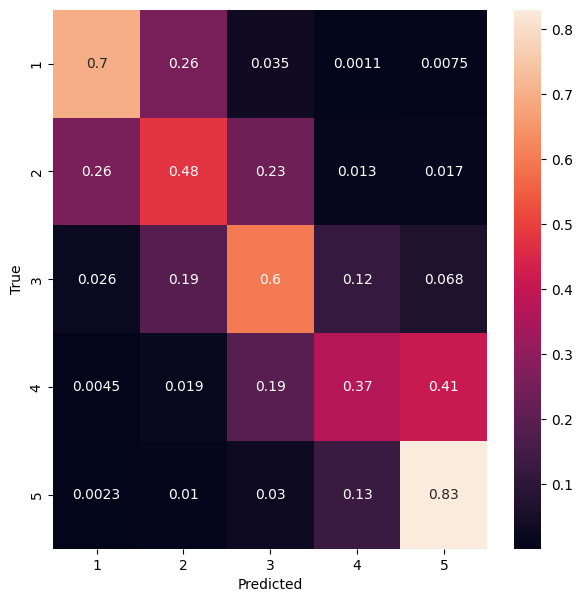

In [25]:
plt.figure(figsize=(7,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")